In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, 
                      padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 14):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_121 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_111 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_143 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_144 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_168 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_156 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_169 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_157 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 16000, 32)         3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5281 - acc: 0.3736
Epoch 00001: val_loss improved from inf to 2.18427, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_3_conv_checkpoint/001-2.1843.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.5278 - acc: 0.3736 - val_loss: 2.1843 - val_acc: 0.3659
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8666 - acc: 0.7555
Epoch 00002: val_loss did not improve from 2.18427
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.8666 - acc: 0.7554 - val_loss: 2.2440 - val_acc: 0.4451
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3309 - acc: 0.9204
Epoch 00003: val_loss improved from 2.18427 to 2.18309, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_3_conv_checkpoint/

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9943
Epoch 00029: val_loss did not improve from 2.18309
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0379 - acc: 0.9942 - val_loss: 4.5275 - val_acc: 0.4433
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9893
Epoch 00030: val_loss did not improve from 2.18309
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0558 - acc: 0.9892 - val_loss: 4.3513 - val_acc: 0.4542
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9910
Epoch 00031: val_loss did not improve from 2.18309
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0483 - acc: 0.9910 - val_loss: 4.2554 - val_acc: 0.4612
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9947
Epoch 00032: val_loss did not improve from 2.18309
36805/36805 [===========

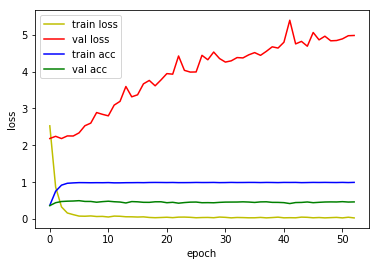

4815/4815 [==============================] - 5s 939us/sample - loss: 2.3763 - acc: 0.4390
Loss: 2.3762977059385118 Accuracy: 0.43904465

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2171 - acc: 0.4011
Epoch 00001: val_loss improved from inf to 1.94851, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_4_conv_checkpoint/001-1.9485.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 2.2174 - acc: 0.4011 - val_loss: 1.9485 - val_acc: 0.4144
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0612 - acc: 0.6868
Epoch 00002: val_loss did not improve from 1.94851
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.0612 - acc: 0.6868 - val_loss: 1.9897 - val_acc: 0.4761
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5502 - acc: 0.8440
Epoch 00003: val_loss improved from 1.94851 to 1.65778, sa

36800/36805 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9911
Epoch 00029: val_loss did not improve from 1.65778
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0406 - acc: 0.9911 - val_loss: 2.7364 - val_acc: 0.5481
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9938
Epoch 00030: val_loss did not improve from 1.65778
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0313 - acc: 0.9938 - val_loss: 2.7524 - val_acc: 0.5544
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9960
Epoch 00031: val_loss did not improve from 1.65778
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0261 - acc: 0.9960 - val_loss: 2.8025 - val_acc: 0.5516
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9954
Epoch 00032: val_loss did not improve from 1.65778
36805/36805 [========================

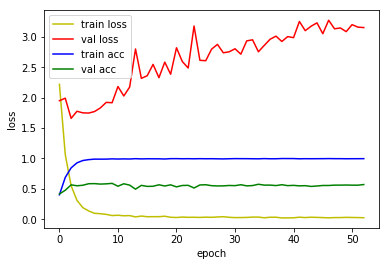

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.7769 - acc: 0.5090
Loss: 1.7768519674134775 Accuracy: 0.5090343

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1290 - acc: 0.4158
Epoch 00001: val_loss improved from inf to 2.01533, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_5_conv_checkpoint/001-2.0153.hdf5
36805/36805 [==============================] - 124s 3ms/sample - loss: 2.1293 - acc: 0.4158 - val_loss: 2.0153 - val_acc: 0.4274
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1135 - acc: 0.6705
Epoch 00002: val_loss improved from 2.01533 to 1.54101, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_5_conv_checkpoint/002-1.5410.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 1.1136 - acc: 0.6705 - val_loss: 1.5410 - val_acc: 0.5779
Epoch 3/500
36800/36805 [==================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9912
Epoch 00029: val_loss did not improve from 1.47902
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0359 - acc: 0.9912 - val_loss: 2.5323 - val_acc: 0.6040
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9930
Epoch 00030: val_loss did not improve from 1.47902
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0290 - acc: 0.9930 - val_loss: 2.6096 - val_acc: 0.5956
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9949
Epoch 00031: val_loss did not improve from 1.47902
36805/36805 [==============================] - 100s 3ms/sample - loss: 0.0263 - acc: 0.9949 - val_loss: 2.5469 - val_acc: 0.5919
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9927
Epoch 00032: val_loss did not improve from 1.47902
36805/36805 [========

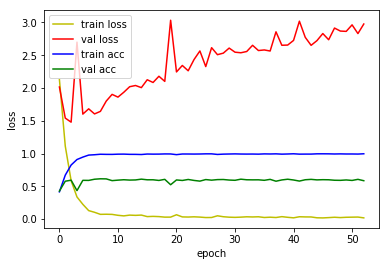

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.5917 - acc: 0.5634
Loss: 1.591745559201186 Accuracy: 0.56344754

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0157 - acc: 0.4157
Epoch 00001: val_loss improved from inf to 1.78228, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_6_conv_checkpoint/001-1.7823.hdf5
36805/36805 [==============================] - 138s 4ms/sample - loss: 2.0157 - acc: 0.4158 - val_loss: 1.7823 - val_acc: 0.4640
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2304 - acc: 0.6371
Epoch 00002: val_loss improved from 1.78228 to 1.44131, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_6_conv_checkpoint/002-1.4413.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.2305 - acc: 0.6371 - val_loss: 1.4413 - val_acc: 0.5952
Epoch 3/500
36800/36805 [==================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9907
Epoch 00028: val_loss did not improve from 1.15969
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.0416 - acc: 0.9906 - val_loss: 1.5847 - val_acc: 0.6790
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9898
Epoch 00029: val_loss did not improve from 1.15969
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.0440 - acc: 0.9898 - val_loss: 1.6131 - val_acc: 0.6897
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9958
Epoch 00030: val_loss did not improve from 1.15969
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.0258 - acc: 0.9957 - val_loss: 1.6372 - val_acc: 0.6827
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0549 - acc: 0.9864
Epoch 00031: val_loss did not improve from 1.15969
36805/36805 [========

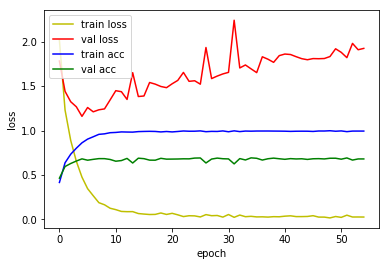

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.2420 - acc: 0.6478
Loss: 1.2419819713505382 Accuracy: 0.64776736

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1096 - acc: 0.3707
Epoch 00001: val_loss improved from inf to 1.62609, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_7_conv_checkpoint/001-1.6261.hdf5
36805/36805 [==============================] - 148s 4ms/sample - loss: 2.1097 - acc: 0.3707 - val_loss: 1.6261 - val_acc: 0.4871
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3245 - acc: 0.5957
Epoch 00002: val_loss improved from 1.62609 to 1.20341, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_7_conv_checkpoint/002-1.2034.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.3244 - acc: 0.5957 - val_loss: 1.2034 - val_acc: 0.6394
Epoch 3/500
36800/36805 [=================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9878
Epoch 00028: val_loss did not improve from 0.90744
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0597 - acc: 0.9877 - val_loss: 1.2132 - val_acc: 0.7442
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0643 - acc: 0.9857
Epoch 00029: val_loss did not improve from 0.90744
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0643 - acc: 0.9857 - val_loss: 1.1132 - val_acc: 0.7477
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9897
Epoch 00030: val_loss did not improve from 0.90744
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0500 - acc: 0.9897 - val_loss: 1.1867 - val_acc: 0.7424
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9899
Epoch 00031: val_loss did not improve from 0.90744
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9938
Epoch 00058: val_loss did not improve from 0.90744
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0294 - acc: 0.9938 - val_loss: 1.3274 - val_acc: 0.7510
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9919
Epoch 00059: val_loss did not improve from 0.90744
36805/36805 [==============================] - 107s 3ms/sample - loss: 0.0333 - acc: 0.9919 - val_loss: 1.3908 - val_acc: 0.7512

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_7_conv Model


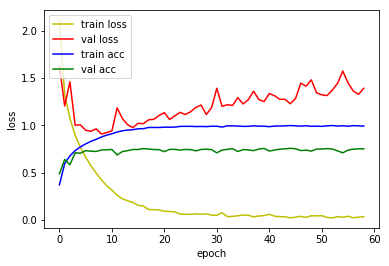

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9970 - acc: 0.7086
Loss: 0.996963969544582 Accuracy: 0.7086189

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2275 - acc: 0.3283
Epoch 00001: val_loss improved from inf to 1.89366, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_8_conv_checkpoint/001-1.8937.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 2.2274 - acc: 0.3283 - val_loss: 1.8937 - val_acc: 0.3969
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4429 - acc: 0.5555
Epoch 00002: val_loss improved from 1.89366 to 1.32207, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_8_conv_checkpoint/002-1.3221.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 1.4429 - acc: 0.5555 - val_loss: 1.3221 - val_acc: 0.5993
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1185 - acc: 0.9707
Epoch 00025: val_loss did not improve from 0.62021
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.1186 - acc: 0.9706 - val_loss: 0.7407 - val_acc: 0.8181
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9669
Epoch 00026: val_loss did not improve from 0.62021
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.1229 - acc: 0.9669 - val_loss: 0.8726 - val_acc: 0.7885
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1035 - acc: 0.9746
Epoch 00027: val_loss did not improve from 0.62021
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.1038 - acc: 0.9746 - val_loss: 0.6843 - val_acc: 0.8409
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9728
Epoch 00028: val_loss did not improve from 0.62021
36805/36805 [=====================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9909
Epoch 00055: val_loss did not improve from 0.62021
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.0400 - acc: 0.9908 - val_loss: 0.7956 - val_acc: 0.8341
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9869
Epoch 00056: val_loss did not improve from 0.62021
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.0507 - acc: 0.9868 - val_loss: 0.7405 - val_acc: 0.8488
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9887
Epoch 00057: val_loss did not improve from 0.62021
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.0455 - acc: 0.9886 - val_loss: 0.8028 - val_acc: 0.8339
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9899
Epoch 00058: val_loss did not improve from 0.62021
36805/36805 [========

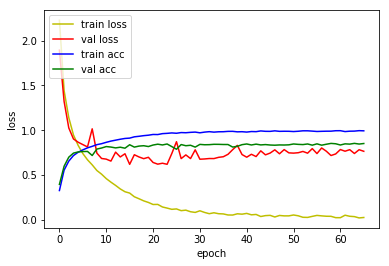

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.6865 - acc: 0.8123
Loss: 0.6865143270631198 Accuracy: 0.81225336

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2520 - acc: 0.3258
Epoch 00001: val_loss improved from inf to 1.95942, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_9_conv_checkpoint/001-1.9594.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 2.2520 - acc: 0.3258 - val_loss: 1.9594 - val_acc: 0.3958
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3742 - acc: 0.5827
Epoch 00002: val_loss improved from 1.95942 to 1.19885, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_9_conv_checkpoint/002-1.1989.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.3745 - acc: 0.5827 - val_loss: 1.1989 - val_acc: 0.6473
Epoch 3/500
36800/36805 [=================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0918 - acc: 0.9735
Epoch 00026: val_loss did not improve from 0.40682
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0918 - acc: 0.9735 - val_loss: 0.4303 - val_acc: 0.8954
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9837
Epoch 00027: val_loss did not improve from 0.40682
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0638 - acc: 0.9836 - val_loss: 0.4675 - val_acc: 0.8894
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0872 - acc: 0.9751
Epoch 00028: val_loss did not improve from 0.40682
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0873 - acc: 0.9751 - val_loss: 0.4733 - val_acc: 0.8891
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9835
Epoch 00029: val_loss did not improve from 0.40682
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9948
Epoch 00056: val_loss did not improve from 0.40682
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0232 - acc: 0.9948 - val_loss: 0.4878 - val_acc: 0.8998
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9907
Epoch 00057: val_loss did not improve from 0.40682
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0341 - acc: 0.9907 - val_loss: 0.4912 - val_acc: 0.9022
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9890
Epoch 00058: val_loss did not improve from 0.40682
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0405 - acc: 0.9890 - val_loss: 0.5070 - val_acc: 0.8994
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9880
Epoch 00059: val_loss did not improve from 0.40682
36805/36805 [========

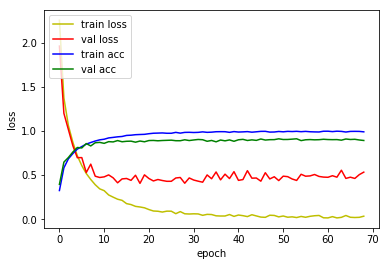

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.4907 - acc: 0.8613
Loss: 0.4906679555139314 Accuracy: 0.86126685

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3549 - acc: 0.2873
Epoch 00001: val_loss improved from inf to 1.90977, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_conv_checkpoint/001-1.9098.hdf5
36805/36805 [==============================] - 203s 6ms/sample - loss: 2.3548 - acc: 0.2874 - val_loss: 1.9098 - val_acc: 0.4069
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4207 - acc: 0.5696
Epoch 00002: val_loss improved from 1.90977 to 1.23648, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_conv_checkpoint/002-1.2365.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 1.4206 - acc: 0.5696 - val_loss: 1.2365 - val_acc: 0.6252
Epoch 3/500
36800/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0751 - acc: 0.9793
Epoch 00024: val_loss improved from 0.29270 to 0.27612, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_conv_checkpoint/024-0.2761.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0752 - acc: 0.9792 - val_loss: 0.2761 - val_acc: 0.9278
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9778
Epoch 00025: val_loss improved from 0.27612 to 0.27268, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_conv_checkpoint/025-0.2727.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0759 - acc: 0.9777 - val_loss: 0.2727 - val_acc: 0.9292
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9752
Epoch 00026: val_loss improved from 0.27268 to 0.26963, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_c

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9930
Epoch 00052: val_loss did not improve from 0.26376
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0249 - acc: 0.9930 - val_loss: 0.2757 - val_acc: 0.9329
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9961
Epoch 00053: val_loss did not improve from 0.26376
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0174 - acc: 0.9961 - val_loss: 0.2787 - val_acc: 0.9380
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9957
Epoch 00054: val_loss improved from 0.26376 to 0.25469, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_conv_checkpoint/054-0.2547.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0176 - acc: 0.9957 - val_loss: 0.2547 - val_acc: 0.9380
Epoch 55/500
36800/36805 [============================>

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9920
Epoch 00081: val_loss did not improve from 0.24810
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0280 - acc: 0.9920 - val_loss: 0.2654 - val_acc: 0.9441
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9977
Epoch 00082: val_loss did not improve from 0.24810
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0095 - acc: 0.9976 - val_loss: 0.2695 - val_acc: 0.9408
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9955
Epoch 00083: val_loss did not improve from 0.24810
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0163 - acc: 0.9955 - val_loss: 0.2598 - val_acc: 0.9462
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9956
Epoch 00084: val_loss did not improve from 0.24810
36805/36805 [========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9987
Epoch 00111: val_loss did not improve from 0.24810
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0069 - acc: 0.9987 - val_loss: 0.2729 - val_acc: 0.9401
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9931
Epoch 00112: val_loss did not improve from 0.24810
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0237 - acc: 0.9931 - val_loss: 0.2955 - val_acc: 0.9387
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9946
Epoch 00113: val_loss did not improve from 0.24810
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0176 - acc: 0.9946 - val_loss: 0.2605 - val_acc: 0.9448
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9991
Epoch 00114: val_loss did not improve from 0.24810
36805/36805 [====

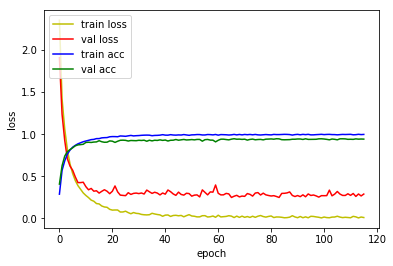

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.3123 - acc: 0.9281
Loss: 0.31234766842791595 Accuracy: 0.92814124

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3168 - acc: 0.2977
Epoch 00001: val_loss improved from inf to 1.87801, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_11_conv_checkpoint/001-1.8780.hdf5
36805/36805 [==============================] - 231s 6ms/sample - loss: 2.3168 - acc: 0.2977 - val_loss: 1.8780 - val_acc: 0.4174
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2914 - acc: 0.6074
Epoch 00002: val_loss improved from 1.87801 to 1.03203, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_11_conv_checkpoint/002-1.0320.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.2915 - acc: 0.6074 - val_loss: 1.0320 - val_acc: 0.6972
Epoch 3/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0733 - acc: 0.9787
Epoch 00025: val_loss did not improve from 0.21103
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0734 - acc: 0.9787 - val_loss: 0.2340 - val_acc: 0.9350
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0727 - acc: 0.9782
Epoch 00026: val_loss did not improve from 0.21103
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0727 - acc: 0.9781 - val_loss: 0.2272 - val_acc: 0.9415
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9838
Epoch 00027: val_loss improved from 0.21103 to 0.20892, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_11_conv_checkpoint/027-0.2089.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0555 - acc: 0.9838 - val_loss: 0.2089 - val_acc: 0.9439
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9902
Epoch 00054: val_loss did not improve from 0.17596
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0333 - acc: 0.9902 - val_loss: 0.2222 - val_acc: 0.9506
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9975
Epoch 00055: val_loss did not improve from 0.17596
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0113 - acc: 0.9975 - val_loss: 0.2107 - val_acc: 0.9495
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9961
Epoch 00056: val_loss did not improve from 0.17596
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0153 - acc: 0.9961 - val_loss: 0.2065 - val_acc: 0.9504
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9925
Epoch 00057: val_loss did not improve from 0.17596
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9963
Epoch 00084: val_loss did not improve from 0.17596
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0130 - acc: 0.9963 - val_loss: 0.1868 - val_acc: 0.9585
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9987
Epoch 00085: val_loss did not improve from 0.17596
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0065 - acc: 0.9986 - val_loss: 0.2382 - val_acc: 0.9483
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9932
Epoch 00086: val_loss did not improve from 0.17596
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0214 - acc: 0.9932 - val_loss: 0.2151 - val_acc: 0.9506
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9963
Epoch 00087: val_loss did not improve from 0.17596
36805/36805 [========

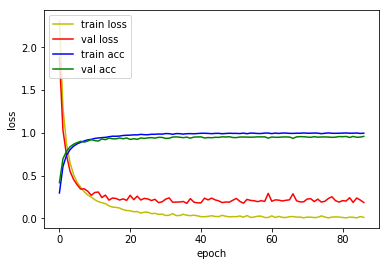

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2364 - acc: 0.9317
Loss: 0.23642852384662827 Accuracy: 0.93167186

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3741 - acc: 0.2783
Epoch 00001: val_loss improved from inf to 2.03832, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_12_conv_checkpoint/001-2.0383.hdf5
36805/36805 [==============================] - 254s 7ms/sample - loss: 2.3741 - acc: 0.2783 - val_loss: 2.0383 - val_acc: 0.3515
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3797 - acc: 0.5714
Epoch 00002: val_loss improved from 2.03832 to 0.99967, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_12_conv_checkpoint/002-0.9997.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 1.3798 - acc: 0.5714 - val_loss: 0.9997 - val_acc: 0.6951
Epoch 3/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9836
Epoch 00025: val_loss did not improve from 0.17710
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0555 - acc: 0.9836 - val_loss: 0.1949 - val_acc: 0.9448
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9843
Epoch 00026: val_loss did not improve from 0.17710
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0546 - acc: 0.9842 - val_loss: 0.1843 - val_acc: 0.9460
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9862
Epoch 00027: val_loss did not improve from 0.17710
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0476 - acc: 0.9862 - val_loss: 0.1958 - val_acc: 0.9471
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9897
Epoch 00028: val_loss did not improve from 0.17710
36805/36805 [=====================

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9976
Epoch 00053: val_loss did not improve from 0.15881
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0103 - acc: 0.9976 - val_loss: 0.1999 - val_acc: 0.9518
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9955
Epoch 00054: val_loss did not improve from 0.15881
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0167 - acc: 0.9955 - val_loss: 0.1887 - val_acc: 0.9525
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9969
Epoch 00055: val_loss did not improve from 0.15881
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0123 - acc: 0.9969 - val_loss: 0.2189 - val_acc: 0.9497
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9967
Epoch 00056: val_loss did not improve from 0.15881
36805/36805 [========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9981
Epoch 00082: val_loss did not improve from 0.15373
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0074 - acc: 0.9981 - val_loss: 0.1768 - val_acc: 0.9578
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9974
Epoch 00083: val_loss did not improve from 0.15373
36805/36805 [==============================] - 115s 3ms/sample - loss: 0.0088 - acc: 0.9973 - val_loss: 0.1884 - val_acc: 0.9590
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9928
Epoch 00084: val_loss did not improve from 0.15373
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0240 - acc: 0.9928 - val_loss: 0.1912 - val_acc: 0.9585
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9990
Epoch 00085: val_loss did not improve from 0.15373
36805/36805 [========

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9974
Epoch 00112: val_loss did not improve from 0.15373
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0093 - acc: 0.9974 - val_loss: 0.1748 - val_acc: 0.9606
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9989
Epoch 00113: val_loss did not improve from 0.15373
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0045 - acc: 0.9989 - val_loss: 0.2083 - val_acc: 0.9541
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9947
Epoch 00114: val_loss did not improve from 0.15373
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0166 - acc: 0.9947 - val_loss: 0.1804 - val_acc: 0.9583
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9968
Epoch 00115: val_loss did not improve from 0.15373
36805/36805 [====

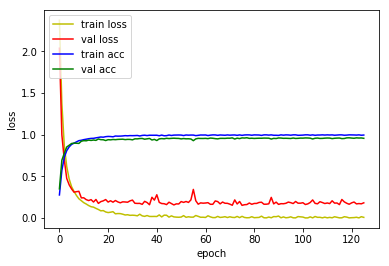

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2247 - acc: 0.9466
Loss: 0.22471464893249707 Accuracy: 0.9466251

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2481 - acc: 0.3051
Epoch 00001: val_loss improved from inf to 1.81755, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_13_conv_checkpoint/001-1.8175.hdf5
36805/36805 [==============================] - 290s 8ms/sample - loss: 2.2481 - acc: 0.3051 - val_loss: 1.8175 - val_acc: 0.4083
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1109 - acc: 0.6427
Epoch 00002: val_loss improved from 1.81755 to 0.88608, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_13_conv_checkpoint/002-0.8861.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 1.1109 - acc: 0.6427 - val_loss: 0.8861 - val_acc: 0.7193
Epoch 3/500
36800/36805 [===============

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9800
Epoch 00025: val_loss improved from 0.21421 to 0.19495, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_13_conv_checkpoint/025-0.1949.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0611 - acc: 0.9800 - val_loss: 0.1949 - val_acc: 0.9462
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9908
Epoch 00026: val_loss did not improve from 0.19495
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0332 - acc: 0.9908 - val_loss: 0.2388 - val_acc: 0.9380
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9882
Epoch 00027: val_loss did not improve from 0.19495
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0388 - acc: 0.9882 - val_loss: 0.2430 - val_acc: 0.9341
Epoch 28/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9968
Epoch 00054: val_loss did not improve from 0.19495
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0114 - acc: 0.9968 - val_loss: 0.2607 - val_acc: 0.9448
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9911
Epoch 00055: val_loss did not improve from 0.19495
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0271 - acc: 0.9911 - val_loss: 0.2319 - val_acc: 0.9436
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9976
Epoch 00056: val_loss did not improve from 0.19495
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0094 - acc: 0.9976 - val_loss: 0.2521 - val_acc: 0.9413
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9957
Epoch 00057: val_loss did not improve from 0.19495
36805/36805 [=====================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9988
Epoch 00083: val_loss did not improve from 0.18747
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0047 - acc: 0.9988 - val_loss: 0.1976 - val_acc: 0.9576
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9972
Epoch 00084: val_loss did not improve from 0.18747
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0088 - acc: 0.9972 - val_loss: 0.2111 - val_acc: 0.9520
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9976
Epoch 00085: val_loss did not improve from 0.18747
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0079 - acc: 0.9976 - val_loss: 0.2370 - val_acc: 0.9497
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9979
Epoch 00086: val_loss did not improve from 0.18747
36805/36805 [========

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9979
Epoch 00113: val_loss did not improve from 0.18747
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0079 - acc: 0.9979 - val_loss: 0.3521 - val_acc: 0.9308
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9942
Epoch 00114: val_loss did not improve from 0.18747
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0171 - acc: 0.9941 - val_loss: 0.2269 - val_acc: 0.9502
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9966
Epoch 00115: val_loss did not improve from 0.18747
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0104 - acc: 0.9966 - val_loss: 0.1937 - val_acc: 0.9574
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9992
Epoch 00116: val_loss did not improve from 0.18747
36805/36805 [====

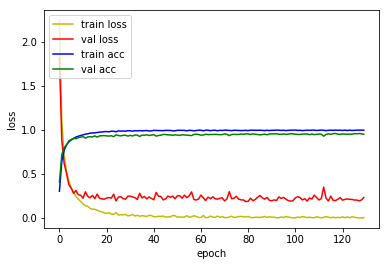

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2468 - acc: 0.9466
Loss: 0.2468474530619748 Accuracy: 0.9466251



In [10]:
base = '1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN'

for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 14):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_195 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_182 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_196 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_183 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_184 (Conv1D)  

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.5917 - acc: 0.5634
Loss: 1.591745559201186 Accuracy: 0.56344754

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_222 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_206 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_223 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_207 (Acti

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.9970 - acc: 0.7086
Loss: 0.996963969544582 Accuracy: 0.7086189

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_250 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_232 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_251 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_233 (Activ

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.6865 - acc: 0.8123
Loss: 0.6865143270631198 Accuracy: 0.81225336

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_267 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_248 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_268 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_249 (Ac

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.4907 - acc: 0.8613
Loss: 0.4906679555139314 Accuracy: 0.86126685

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_286 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_266 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_287 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_267 (A

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.3123 - acc: 0.9281
Loss: 0.31234766842791595 Accuracy: 0.92814124

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_307 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_286 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_308 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_287 (

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2364 - acc: 0.9317
Loss: 0.23642852384662827 Accuracy: 0.93167186

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_330 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_308 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_331 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_309 (

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2247 - acc: 0.9466
Loss: 0.22471464893249707 Accuracy: 0.9466251

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_355 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_332 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_356 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_333 (A

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2468 - acc: 0.9466
Loss: 0.2468474530619748 Accuracy: 0.9466251


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_195 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_182 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_196 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_183 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_184 (Conv1D)  

4815/4815 [==============================] - 12s 2ms/sample - loss: 3.3140 - acc: 0.5497
Loss: 3.313974734135011 Accuracy: 0.5497404

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_222 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_206 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_223 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_207 (Acti

4815/4815 [==============================] - 13s 3ms/sample - loss: 1.4852 - acc: 0.7252
Loss: 1.4851543031377585 Accuracy: 0.7252337

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_250 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_232 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_251 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_233 (Act

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.8582 - acc: 0.8249
Loss: 0.8581665458956488 Accuracy: 0.82492214

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_267 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_248 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_268 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_249 (Ac

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.6301 - acc: 0.8694
Loss: 0.6301451848612891 Accuracy: 0.8693666

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_286 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_266 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_287 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_267 (Ac

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.3344 - acc: 0.9279
Loss: 0.33438433541965634 Accuracy: 0.9279335

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_307 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_286 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_308 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_287 (A

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.2348 - acc: 0.9445
Loss: 0.23478842405051087 Accuracy: 0.9445483

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_330 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_308 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_331 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_309 (A

4815/4815 [==============================] - 15s 3ms/sample - loss: 0.2314 - acc: 0.9489
Loss: 0.23144411892859365 Accuracy: 0.94890964

1D_CNN_custom_conv_3_VGG_pool_2_ch_32_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_355 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_332 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_356 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_333 (

4815/4815 [==============================] - 16s 3ms/sample - loss: 0.3126 - acc: 0.9391
Loss: 0.3125982077776813 Accuracy: 0.9391485
